In [250]:
setwd("/Users/rebecca/sudmant/analyses/myotis/analysis/exploratory/species_peaks")

library(dplyr)
library(scales)
library(ggplot2)
library(data.table)
library(GenomicRanges)

myo_meta <- read.csv("/Users/rebecca/sudmant/analyses/myotis/data/myotis_meta.csv")

In [277]:
## Which TEs are in accessible vs. inaccessible regions?

frac_TEs_list <- lapply(seq_along(myo_meta$Abbr), function(i) {

  ## Load in TE peak data
  features_peaks <- fread(
    file.path("results/data", paste0(myo_meta$Abbr[i], "_TEs_peaks.tsv")), 
    data.table = FALSE
  )
  
  features_peaks$Type <- features_peaks$V7
  features_peaks$Type[grep("^DNA", features_peaks$Type)] <- "DNA"
  features_peaks$Type[grep("^SINE", features_peaks$Type)] <- "SINE"
  features_peaks$Type[grep("^LINE", features_peaks$Type)] <- "LINE"
  features_peaks$Type[grep("^LTR", features_peaks$Type)] <- "LTR"
  features_peaks$Type[grep("^Simple", features_peaks$Type)] <- "Simple repeat"
  features_peaks$Type[grep("Unknown", features_peaks$Type)] <- "Unknown"
  features_peaks$Type[grep("RNA", features_peaks$Type)] <- "rRNA/tRNA/snRNA"
  features_peaks$Type[grep("^Sat", features_peaks$Type)] <- "Other"
  features_peaks$Type[grep("^Retro", features_peaks$Type)] <- "Other"
  features_peaks$Type <- gsub("_", " ", features_peaks$Type)
                          
  ## Which TEs are occupied by peaks?
  df <- features_peaks %>%
    dplyr::group_by(ID = paste(V1, V2, V3)) %>% 
    dplyr::reframe(
      Peak_ID = paste(unique(V11), collapse = ", "),
      Type = paste(unique(Type), collapse = ", "),
      DNA_Type = paste(unique(V7), collapse = ", ")
    ) %>%
    dplyr::mutate(
      Peak = ifelse(Peak_ID == ".", FALSE, TRUE),
      Type = ifelse(grepl(",", Type), "Unknown", Type),
      DNA_Type = ifelse(grepl(",", DNA_Type), "Unknown", DNA_Type)
    ) %>%
    dplyr::group_by(Type, DNA_Type, Peak) %>%
    dplyr::reframe(No.Elements = n()) %>%
    dplyr::mutate(Species = myo_meta$Field_Name[i])
    
  return(df)
  
})

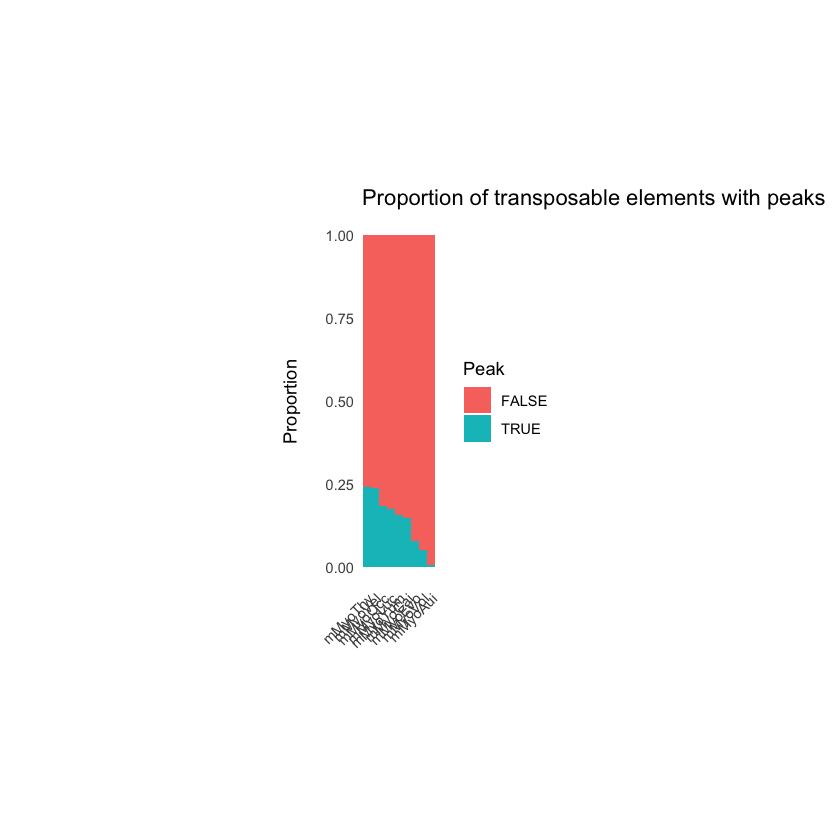

In [272]:
## Proportion of TEs with peaks per species

pdf("results/figures/TE_peak_proportion.pdf", width = 13, height = 9)

## Summarize over all TE types:

df <- do.call(rbind, frac_TEs_list) %>%
  dplyr::group_by(Species) %>%
  dplyr::mutate(
    Frac_TEs = No.Elements/sum(No.Elements)
  )
  
x_order <- df %>%
  dplyr::filter(Peak == TRUE) %>%
  dplyr::group_by(Species) %>%
  dplyr::reframe(n = sum(Frac_TEs)) %>%
  dplyr::arrange(desc(n))
  
df$Species <- factor(df$Species, levels = x_order$Species)

print(
  ggplot(df, aes(x = Species, y = Frac_TEs, fill = Peak)) +
    geom_bar(stat = "identity") +
    theme_minimal() +
    theme(axis.title.x = element_blank(),
          axis.text.x = element_text(angle = 45, hjust = 1),
          axis.title.y = element_text(margin = margin(r = 15)),
          panel.grid = element_blank(),
          plot.margin = unit(c(4, 6, 4, 6), "cm")) +
    labs(title = "Proportion of transposable elements with peaks") +
    ylab("Proportion")
)

## Stratify by TE type:

print(
  ggplot(df, aes(x = Type, y = Frac_TEs, fill = Peak)) +
    geom_bar(stat = "identity") +
    theme_minimal() +
    theme(axis.title.x = element_blank(),
          axis.text.x = element_text(angle = 45, hjust = 1),
          axis.title.y = element_text(margin = margin(r = 15)),
          panel.grid = element_blank(),
          plot.margin = unit(c(1, 3, 1, 3), "cm")) +
    labs(title = "Proportion of transposable elements with peaks") +
    ylab("Proportion") +
    facet_wrap(. ~ Species)
)

# print(
#   ggplot(df_all, aes(x = Type, y = No.Elements, fill = Peak)) +
#     geom_bar(stat = "identity") +
#     theme_minimal() +
#     theme(axis.title.x = element_blank(),
#           axis.text.x = element_text(angle = 45, hjust = 1),
#           axis.title.y = element_text(margin = margin(r = 15)),
#           panel.grid = element_blank(),
#           plot.margin = unit(c(1, 3, 1, 3), "cm")) +
#     labs(title = "# of transposable elements with peaks") +
#     ylab("# elements") + scale_y_continuous(labels = comma) +
#     facet_wrap(. ~ Species)
# )

## Subset to DNA elements:

df_DNA <- df %>%
  dplyr::filter(grepl("DNA", Type)) %>%
  dplyr::group_by(Species) %>%
  dplyr::mutate(
    Frac_TEs = No.Elements/sum(No.Elements)
  )
  
print(
  ggplot(df_DNA, aes(x = DNA_Type, y = Frac_TEs, fill = Peak)) +
    geom_bar(stat = "identity") +
    theme_minimal() +
    theme(axis.title.x = element_blank(),
          axis.text.x = element_text(angle = 45, hjust = 1, size = 6),
          axis.title.y = element_text(margin = margin(r = 15)),
          panel.grid = element_blank(),
          plot.margin = unit(c(1, 1, 1, 1), "cm")) +
    labs(title = "Proportion of transposable elements with peaks") +
    ylab("Proportion") +
    facet_wrap(. ~ Species, scales = "free_x")
)

dev.off()

In [ ]:
## Plot TE divergence in accessible vs. nonaccessible regions:

feature_files <- list.files(path = "results/data", 
                            pattern = "TEs_peaks.tsv", 
                            full.names = TRUE)

pdf("results/figures/peak_status_vs_TE_divergence.pdf", width = 6, height = 7)

lapply(seq_along(myo_meta$Abbr), function(i) {
  
  ## Load in feature data with intersecting peaks (file contains all features for a given species, irrespective of whether they intersected a peak)
  features_peaks <- fread(
    feature_files[grep(myo_meta$Abbr[i], feature_files)], 
    data.table = FALSE
  )
  
  ## Group by feature, and collapse all peaks associated with that feature
  df <- features_peaks %>%
    dplyr::mutate(ID = paste(V1, V2, V3, V7)) %>% 
    dplyr::group_by(ID) %>%
    dplyr::reframe(
      Peak_ID = paste(unique(V11), collapse = ", "),
      Type = unique(V7),
      Divergence = unique(V5) 
    ) %>%
    dplyr::mutate(
      Peak = ifelse(Peak_ID == ".", "No peak", "Peak")
    )

  df$Peak <- factor(df$Peak, levels = c("Peak", "No peak"))
    
  print(
    ggplot(df, aes(x = Peak, y = Divergence)) +
      geom_violin(color = "grey", fill = "grey") +
      geom_boxplot(notch = TRUE, width = .3, outlier.shape = NA) +
      theme_minimal() +
      theme(axis.title.x = element_text(margin = margin(t = 10)),
            axis.text.x = element_text(),
            axis.title.y = element_text(margin = margin(r = 15)),
            plot.margin = unit(c(1, 1, 1, 1), "cm")) +
      labs(title = myo_meta$Field_Name[i], 
            subtitle = "Transposable element divergence") +
      xlab("TE status") + ylab("Divergence") +
      scale_y_continuous(labels = comma) 
  )
  
  print(
    ggplot(subset(df, grepl("DNA", Type)), aes(x = Peak, y = Divergence)) +
      geom_violin(color = "grey", fill = "grey") +
      geom_boxplot(notch = TRUE, width = .3, outlier.shape = NA) +
      theme_minimal() +
      theme(axis.title.x = element_text(margin = margin(t = 10)),
            axis.text.x = element_text(),
            axis.title.y = element_text(margin = margin(r = 15)),
            plot.margin = unit(c(1, 1, 1, 1), "cm")) +
      labs(title = myo_meta$Field_Name[i], 
            subtitle = "DNA transposable element divergence") +
      xlab("TE status") + ylab("Divergence") +
      scale_y_continuous(labels = comma) 
  )
  
})
       
dev.off()

In [206]:
## Plot proportion of peaks with TEs

frac_peaks_list <- lapply(seq_along(myo_meta$Abbr), function(i) {
  
  peak_features <- fread(
    file.path("results/data", paste0(myo_meta$Abbr[i], "_peaks_TEs.tsv")),
    data.table = FALSE
  )
  peak_features$Type <- peak_features$V11
  peak_features$Type[grep("^DNA", peak_features$Type)] <- "DNA"
  peak_features$Type[grep("^SINE", peak_features$Type)] <- "SINE"
  peak_features$Type[grep("^LINE", peak_features$Type)] <- "LINE"
  peak_features$Type[grep("^LTR", peak_features$Type)] <- "LTR"
  peak_features$Type[grep("^Simple", peak_features$Type)] <- "Simple repeat"
  peak_features$Type[grep("Unknown", peak_features$Type)] <- "Unknown"
  peak_features$Type[grep("RNA", peak_features$Type)] <- "rRNA/tRNA/snRNA"
  peak_features$Type[grep("^Sat", peak_features$Type)] <- "Other"
  peak_features$Type[grep("^Retro", peak_features$Type)] <- "Other"
  peak_features$Type[peak_features$Type == "."] <- "NA"
  peak_features$Type <- gsub("_", " ", peak_features$Type)
  
  df <- peak_features %>%
    dplyr::mutate(TE = ifelse(V10 == ".", FALSE, TRUE)) %>%
    dplyr::group_by(V4) %>%
    dplyr::reframe(
      TE = unique(TE),
      Type = paste(unique(Type), collapse = ", ")
    ) %>%
    dplyr::mutate(
      Type = ifelse(grepl(",", Type), "Unknown", Type)
    ) %>%
    dplyr::group_by(TE, Type) %>%
    dplyr::reframe(No.Peaks = n()) %>%
    dplyr::mutate(Species = myo_meta$Field_Name[i])
  
  return(df)
  
})

df <- do.call(rbind, frac_peaks_list)

df <- df %>%
  dplyr::group_by(Species) %>%
  dplyr::mutate(Frac_Peaks = No.Peaks/sum(No.Peaks))
  
x_order <- df %>%
  dplyr::filter(TE == TRUE) %>%
  dplyr::group_by(Species) %>%
  dplyr::summarise(n = sum(Frac_Peaks)) %>%
  dplyr::arrange(desc(n))
  
df$Species <- factor(df$Species, levels = x_order$Species)
  
pdf("results/figures/peak_TE_proportion.pdf", width = 8, height = 6)

print(
  ggplot(df, aes(x = Species, y = Frac_Peaks, fill = TE, color = TE)) +
    geom_bar(stat = "identity") +
    theme_minimal() +
    theme(axis.title.x = element_blank(),
          axis.text.x = element_text(angle = 45, hjust = 1),
          axis.title.y = element_text(margin = margin(r = 15)),
          plot.margin = unit(c(1, 1, 1, 1), "cm")) +
    labs(title = "Proportion of peaks in transposable elements") +
    ylab("Proportion") 
)

## Stratify by TE type:

df_type <- df %>%
  dplyr::filter(TE == TRUE) %>%
  dplyr::group_by(Species) %>%
  dplyr::mutate(Frac_Peaks = No.Peaks/sum(No.Peaks))
  
x_order <- df_type %>%
  dplyr::group_by(Type) %>%
  dplyr::reframe(n = mean(Frac_Peaks)) %>%
  dplyr::arrange(desc(n))

df_type$Type <- factor(df_type$Type, levels = x_order$Type)

print(
  ggplot(df_type, aes(x = Type, y = Frac_Peaks)) +
    geom_bar(stat = "identity") +
    theme_minimal() +
    theme(axis.title.x = element_blank(),
          axis.text.x = element_text(angle = 45, hjust = 1, size = 7),
          axis.title.y = element_text(margin = margin(r = 15)),
          panel.grid = element_blank(),
          plot.margin = unit(c(1, 3, 1, 3), "cm")) +
    labs(title = "Proportion of peaks in transposable elements") +
    ylab("Proportion") +
    facet_wrap(. ~ Species)
)

dev.off()

In [ ]:
## Plot fraction of genome comprised of TEs 

frac_genome_list <- lapply(seq_along(myo_meta$Abbr), function(i) {

  ## Load in TE GTF
  spec_TEs <- fread(file.path("/Users/rebecca/sudmant/analyses/myotis/data/genomes/bat_genomes/repeatMasker", 
                              paste0(myo_meta$Abbr[i], "1_repetMasker.gff3")), skip = 1, data.table = FALSE)

  ## Load in chromosome lengths
  chromsize <- fread(paste0("/Users/rebecca/sudmant/analyses/myotis/data/", 
                            myo_meta$Abbr[i], "_chromsizes"), 
                     data.table = FALSE)

  # ## Load in TE peak data
  # features_peaks <- fread(
  #   file.path("results/data", paste0(myo_meta$Abbr[i], "_TEs_peaks.tsv")), 
  #   data.table = FALSE
  # )
                          
  ## Get fraction of genome occupied by TEs
  spec_TEs <- spec_TEs[,c(1, 4:5, 7)] 
  colnames(spec_TEs) <- c("seqnames", "start", "end", "strand")
  bps_TEs <- sum(width(GenomicRanges::reduce(
    makeGRangesFromDataFrame(spec_TEs, ignore.strand = TRUE)
  )))
  frac_genome <- bps_TEs/sum(chromsize[,2])

  # ## Get fraction of TEs occupied by peaks:
  # features_peaks <- features_peaks %>%
  #   dplyr::group_by(ID = paste(V1, V2, V3)) %>% 
  #   dplyr::reframe(
  #     Peak_ID = paste(unique(V11), collapse = ", ")
  #   ) %>%
  #   dplyr::mutate(
  #     Peak = ifelse(Peak_ID == ".", FALSE, TRUE)
  #   )
  # frac_peaks <- sum(features_peaks$Peak)/nrow(features_peaks)       

  return(data.frame(Species = myo_meta$Field_Name[i], 
                    Frac_Genome = frac_genome)) # , Frac_Peaks = frac_peaks
  
}) 

df <- do.call(rbind, frac_genome_list)
df <- df[rev(order(df$Frac_Genome)),]

df$Species <- factor(df$Species, levels = df$Species)

pdf("results/figures/genome_TE_proportion.pdf", width = 8, height = 8)

print(
  ggplot(df, aes(x = Species, y = Frac_Genome)) +
    geom_bar(stat = "identity") +
    theme_minimal() +
    theme(axis.title.x = element_blank(),
          axis.text.x = element_text(angle = 45, hjust = 1),
          axis.title.y = element_text(margin = margin(r = 15)),
          plot.margin = unit(c(1, 1, 1, 1), "cm")) +
    labs(title = "Fraction of genome comprised of transposable elements") +
    ylab("Fraction") +
    scale_y_continuous(limits = c(0, .25))
)

dev.off()